Importing Libraries

In [2]:
import numpy as np
import struct
import pickle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Load the data

In [3]:
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

dataset = load_mnist_images('archive/train-images.idx3-ubyte')
dataset = dataset.reshape(60000, -1)
labels = load_mnist_labels('archive/train-labels.idx1-ubyte')
labels = labels.reshape(60000, 1)
print("Train Images shape:", dataset.shape)
print("Train Labels shape:", labels.shape)

Train Images shape: (60000, 784)
Train Labels shape: (60000, 1)


Random shuffle the data using seed 42 and normalize the dataset

In [4]:
np.random.seed(42)

indices = np.arange(len(dataset))
np.random.shuffle(indices)
shuffled_images = dataset[indices]
shuffled_labels = labels[indices]

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = np.split(shuffled_images, [train_size, train_size + val_size])
train_labels, val_labels, test_labels = [label.T for label in np.split(shuffled_labels, [train_size, train_size + val_size])]

scaler = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(train_set)
val_set = scaler.transform(val_set)
test_set = scaler.transform(test_set)

train_set = train_set.T
val_set = val_set.T
test_set = test_set.T

print("Train set:", train_set.shape, train_labels.shape)
print("Validation set:", val_set.shape, val_labels.shape)
print("Test set:", test_set.shape, test_labels.shape)


Train set: (784, 48000) (1, 48000)
Validation set: (784, 6000) (1, 6000)
Test set: (784, 6000) (1, 6000)


Defining the activation functions and their gradients

In [5]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_grad(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_matrix = np.exp(x - np.max(x, axis=0, keepdims=True))
    softmax_matrix = exp_matrix / np.sum(exp_matrix, axis=0, keepdims=True)
    return softmax_matrix

def tanh_grad(x):
    return 1 - np.tanh(x) ** 2


def relu(x):
    return np.where(x > 0, x, 0)

def relu_grad(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha= 0.01):
    return np.where(x > 0, x, alpha*x)

def leaky_relu_grad(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)


Defining the weight initialization functions

In [6]:
def zero_init(layer_sizes):
    weights = [np.zeros((layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes)-1)]
    biases = [np.zeros((layer_sizes[i+1], 1)) for i in range(len(layer_sizes)-1)]
    return weights, biases

def random_init(layer_sizes, alpha= 0.25):
    weights = [np.random.randn(layer_sizes[i+1], layer_sizes[i]) * alpha for i in range(len(layer_sizes) - 1)]
    biases = [np.zeros((layer_sizes[i+1], 1)) for i in range(len(layer_sizes) - 1)]
    return weights, biases

def normal_init(layer_sizes):
    # HE Initialization
    weights = [np.random.randn(layer_sizes[i+1], layer_sizes[i]) * np.sqrt(2.0 / layer_sizes[i]) for i in range(len(layer_sizes) - 1)]
    biases = [np.zeros((layer_sizes[i+1], 1)) for i in range(len(layer_sizes) - 1)]
    return weights, biases

In [7]:
train_losses = []
val_losses = []

Neural Network Class:


Attributes:

(a) N: Number of layers in the network.

(b) A list of size N specifying the number of neurons in each layer.

(c) lr: Learning rate

(d) Activation function

(e) Weight initialization function

(f) Number of epochs

(g) Batch size



Methods:

(a) fit(X, Y): trains a model on input data X and labels Y.

(b) predict(X): gives the prediction for input X.

(c) predict_proba(X): gives the class-wise probability for input X.

(d) score(X, Y): gives the accuracy of the trained model on input X and labels Y.

In [ ]:
class NeuralNetwork:

    def __init__(self, N, layer_sizes, lr, act_fn, weight_init_fn, num_epochs, batch_size):
        self.N = N
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.act_fn = act_fn
        self.weight_init_fn = weight_init_fn
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = 0
        self.bias = 0

    def one_hot_encode(self, Y, num_classes= 10):
        one_hot_encoded = np.zeros((Y.size, num_classes))
        one_hot_encoded[np.arange(Y.size), Y] = 1
        return one_hot_encoded.T

    def forward_pass(self, X):
        a_list = [X]
        z_list = []
        
        input_data = X
        for i in range(self.N):
            z = np.dot(self.weights[i], input_data) + self.biases[i]
            z_list.append(z)
            a = self.act_fn(z)
            a_list.append(a)
            input_data = a
        
        z = np.dot(self.weights[self.N], input_data)
        z_list.append(z)
        a = softmax(z)
        a_list.append(a)
        return a_list, z_list
    
    def backpropagation(self, X, Y, a_list, z_list):
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        gradients_b = [np.zeros(b.shape) for b in self.biases]

        gradient_z = a_list[-1] - Y
        for l in range(len(self.weights)-1, -1, -1):
            gradients_w[l] = np.dot(gradient_z, a_list[l].T) / X.shape[0]
            gradients_b[l] = np.sum(gradient_z, axis=1, keepdims=True) / X.shape[0]
            if l > 0: # this is the first layer so there would not be a previous dz to go further backwards 
                gradient_z = np.dot(self.weights[l].T, gradient_z) * self.gradient_act_fn()(z_list[l-1])
        return gradients_w, gradients_b
    
    def gradient_act_fn(self):
        if (self.act_fn == sigmoid):
            return sigmoid_grad
        elif (self.act_fn == relu):
            return relu_grad
        elif (self.act_fn == tanh):
            return tanh_grad
        elif (self.act_fn == leaky_relu):
            return leaky_relu_grad
        else:
            print("Error in gradient of activation function")
            return 0
        
    def fit(self, X, Y, val_X, val_Y):
        total_layers = [l for l in self.layer_sizes]
        total_layers.append(10) 
        total_layers.insert(0, 784) 
        self.weights, self.biases = self.weight_init_fn(total_layers)
        
        Y = self.one_hot_encode(Y)
        val_Y = self.one_hot_encode(val_Y)

        for epoch in range(self.num_epochs):
         
            for i in range(0, X.shape[1], self.batch_size):
                X_batch = X[:, i:i+self.batch_size]
                Y_batch = Y[:, i:i+self.batch_size]
                
                a_list, z_list = self.forward_pass(X_batch)
                
                gradients_w, gradients_b = self.backpropagation(X_batch, Y_batch, a_list, z_list)
                
                for l in range(len(self.weights)):
                    self.weights[l] -= self.lr * gradients_w[l]
                    self.biases[l] -= self.lr * gradients_b[l]

            prediction_train = self.predict_prob(X)
            train_loss = -np.sum(Y * np.log(prediction_train)) / X.shape[0]
            print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
            train_losses.append(train_loss)

            prediction_val = self.predict_prob(val_X)
            val_loss = -np.sum(val_Y * np.log(prediction_val + 1e-8)) / val_X.shape[0]
            print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}")
            val_losses.append(val_loss)
        
    def predict_prob(self, X):
        a_list, _ = self.forward_pass(X)
        probabilities = a_list[-1]
        return probabilities

    def predict(self, X):
        probabilities = self.predict_prob(X)
        predictions = np.argmax(probabilities, axis=0)
        return predictions

    def score(self, X, Y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == Y)
        return accuracy

Function for plotting train and validation loss against number of epochs

In [9]:
def plot_loss():
    
    plt.plot(train_losses)
    plt.ylabel('Train Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss vs Epochs')
    plt.show()

    plt.plot(val_losses)
    plt.ylabel('Val Loss')
    plt.title('Val Loss vs Epochs')
    plt.show()

Training the model with sigmoid activation and weights initialized using zero initialization

In [25]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = sigmoid
weight_initialization_function = zero_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 140.9598
Epoch 1, Val Loss: 17.6193
Epoch 2, Train Loss: 140.9477
Epoch 2, Val Loss: 17.6172
Epoch 3, Train Loss: 140.9377
Epoch 3, Val Loss: 17.6155
Epoch 4, Train Loss: 140.9295
Epoch 4, Val Loss: 17.6140
Epoch 5, Train Loss: 140.9228
Epoch 5, Val Loss: 17.6127
Epoch 6, Train Loss: 140.9173
Epoch 6, Val Loss: 17.6116
Epoch 7, Train Loss: 140.9128
Epoch 7, Val Loss: 17.6107
Epoch 8, Train Loss: 140.9091
Epoch 8, Val Loss: 17.6100
Epoch 9, Train Loss: 140.9060
Epoch 9, Val Loss: 17.6093
Epoch 10, Train Loss: 140.9036
Epoch 10, Val Loss: 17.6087
Epoch 11, Train Loss: 140.9015
Epoch 11, Val Loss: 17.6082
Epoch 12, Train Loss: 140.8999
Epoch 12, Val Loss: 17.6078
Epoch 13, Train Loss: 140.8985
Epoch 13, Val Loss: 17.6075
Epoch 14, Train Loss: 140.8974
Epoch 14, Val Loss: 17.6072
Epoch 15, Train Loss: 140.8965
Epoch 15, Val Loss: 17.6069
Epoch 16, Train Loss: 140.8957
Epoch 16, Val Loss: 17.6067
Epoch 17, Train Loss: 140.8951
Epoch 17, Val Loss: 17.6065
Epoch 18, Train

In [26]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "zero_sigmoid.pkl")


Accuracy: 11.233333333333333%


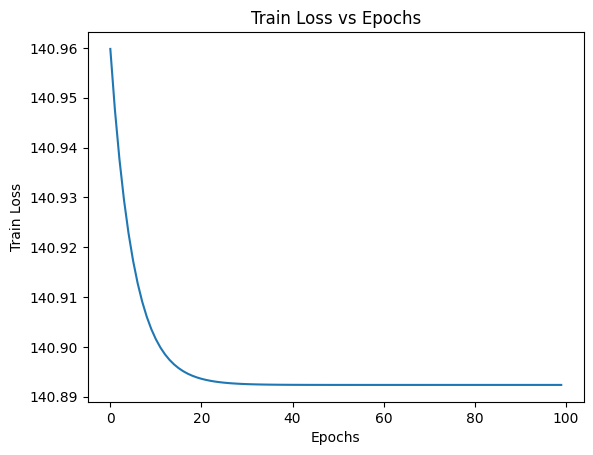

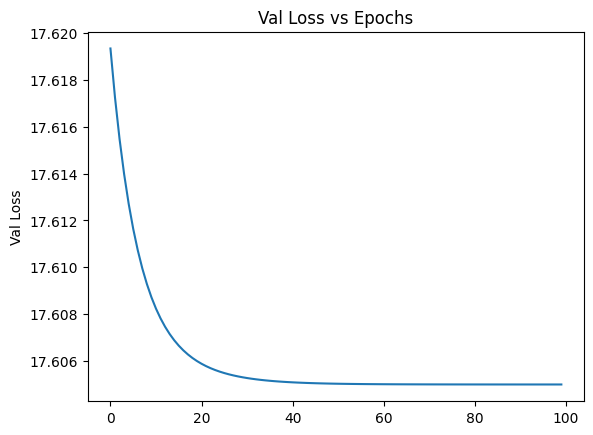

In [27]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with tanh activation and weights initialized using zero initialization

In [28]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = tanh
weight_initialization_function = zero_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 140.9746
Epoch 1, Val Loss: 17.6218
Epoch 2, Train Loss: 140.9746
Epoch 2, Val Loss: 17.6218
Epoch 3, Train Loss: 140.9746
Epoch 3, Val Loss: 17.6218
Epoch 4, Train Loss: 140.9746
Epoch 4, Val Loss: 17.6218
Epoch 5, Train Loss: 140.9746
Epoch 5, Val Loss: 17.6218
Epoch 6, Train Loss: 140.9746
Epoch 6, Val Loss: 17.6218
Epoch 7, Train Loss: 140.9746
Epoch 7, Val Loss: 17.6218
Epoch 8, Train Loss: 140.9746
Epoch 8, Val Loss: 17.6218
Epoch 9, Train Loss: 140.9746
Epoch 9, Val Loss: 17.6218
Epoch 10, Train Loss: 140.9746
Epoch 10, Val Loss: 17.6218
Epoch 11, Train Loss: 140.9746
Epoch 11, Val Loss: 17.6218
Epoch 12, Train Loss: 140.9746
Epoch 12, Val Loss: 17.6218
Epoch 13, Train Loss: 140.9746
Epoch 13, Val Loss: 17.6218
Epoch 14, Train Loss: 140.9746
Epoch 14, Val Loss: 17.6218
Epoch 15, Train Loss: 140.9746
Epoch 15, Val Loss: 17.6218
Epoch 16, Train Loss: 140.9746
Epoch 16, Val Loss: 17.6218
Epoch 17, Train Loss: 140.9746
Epoch 17, Val Loss: 17.6218
Epoch 18, Train

In [29]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "zero_tanh.pkl")

Accuracy: 9.816666666666666%


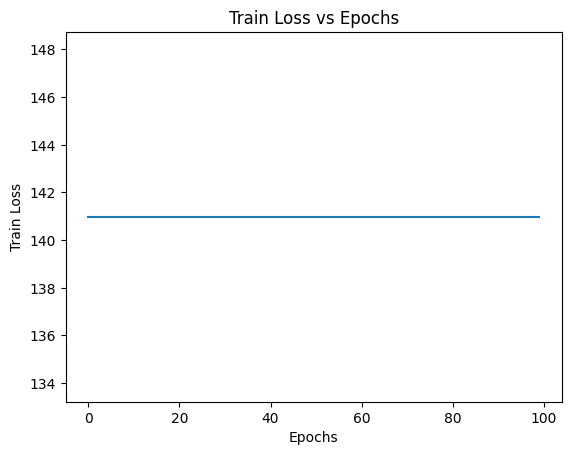

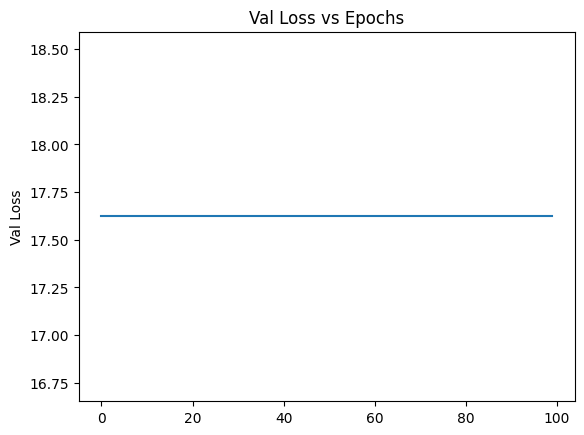

In [30]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with ReLU activation and weights initialized using zero initialization

In [31]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = relu
weight_initialization_function = zero_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 140.9746
Epoch 1, Val Loss: 17.6218
Epoch 2, Train Loss: 140.9746
Epoch 2, Val Loss: 17.6218
Epoch 3, Train Loss: 140.9746
Epoch 3, Val Loss: 17.6218
Epoch 4, Train Loss: 140.9746
Epoch 4, Val Loss: 17.6218
Epoch 5, Train Loss: 140.9746
Epoch 5, Val Loss: 17.6218
Epoch 6, Train Loss: 140.9746
Epoch 6, Val Loss: 17.6218
Epoch 7, Train Loss: 140.9746
Epoch 7, Val Loss: 17.6218
Epoch 8, Train Loss: 140.9746
Epoch 8, Val Loss: 17.6218
Epoch 9, Train Loss: 140.9746
Epoch 9, Val Loss: 17.6218
Epoch 10, Train Loss: 140.9746
Epoch 10, Val Loss: 17.6218
Epoch 11, Train Loss: 140.9746
Epoch 11, Val Loss: 17.6218
Epoch 12, Train Loss: 140.9746
Epoch 12, Val Loss: 17.6218
Epoch 13, Train Loss: 140.9746
Epoch 13, Val Loss: 17.6218
Epoch 14, Train Loss: 140.9746
Epoch 14, Val Loss: 17.6218
Epoch 15, Train Loss: 140.9746
Epoch 15, Val Loss: 17.6218
Epoch 16, Train Loss: 140.9746
Epoch 16, Val Loss: 17.6218
Epoch 17, Train Loss: 140.9746
Epoch 17, Val Loss: 17.6218
Epoch 18, Train

In [32]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "zero_relu.pkl")

Accuracy: 9.816666666666666%


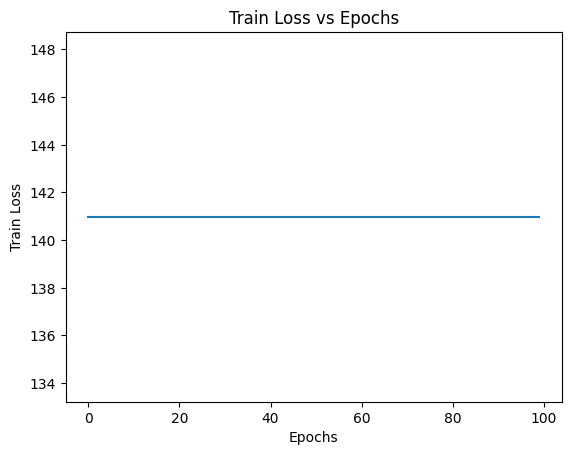

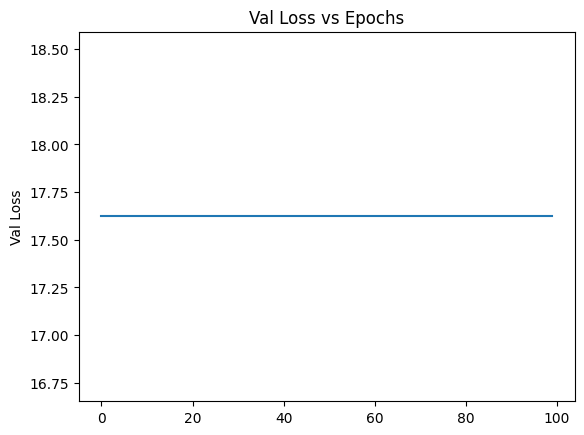

In [33]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with Leaky ReLU activation and weights initialized using zero initialization

In [34]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = leaky_relu
weight_initialization_function = zero_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 140.9746
Epoch 1, Val Loss: 17.6218
Epoch 2, Train Loss: 140.9746
Epoch 2, Val Loss: 17.6218
Epoch 3, Train Loss: 140.9746
Epoch 3, Val Loss: 17.6218
Epoch 4, Train Loss: 140.9746
Epoch 4, Val Loss: 17.6218
Epoch 5, Train Loss: 140.9746
Epoch 5, Val Loss: 17.6218
Epoch 6, Train Loss: 140.9746
Epoch 6, Val Loss: 17.6218
Epoch 7, Train Loss: 140.9746
Epoch 7, Val Loss: 17.6218
Epoch 8, Train Loss: 140.9746
Epoch 8, Val Loss: 17.6218
Epoch 9, Train Loss: 140.9746
Epoch 9, Val Loss: 17.6218
Epoch 10, Train Loss: 140.9746
Epoch 10, Val Loss: 17.6218
Epoch 11, Train Loss: 140.9746
Epoch 11, Val Loss: 17.6218
Epoch 12, Train Loss: 140.9746
Epoch 12, Val Loss: 17.6218
Epoch 13, Train Loss: 140.9746
Epoch 13, Val Loss: 17.6218
Epoch 14, Train Loss: 140.9746
Epoch 14, Val Loss: 17.6218
Epoch 15, Train Loss: 140.9746
Epoch 15, Val Loss: 17.6218
Epoch 16, Train Loss: 140.9746
Epoch 16, Val Loss: 17.6218
Epoch 17, Train Loss: 140.9746
Epoch 17, Val Loss: 17.6218
Epoch 18, Train

In [35]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "zero_leaky_relu.pkl")

Accuracy: 9.816666666666666%


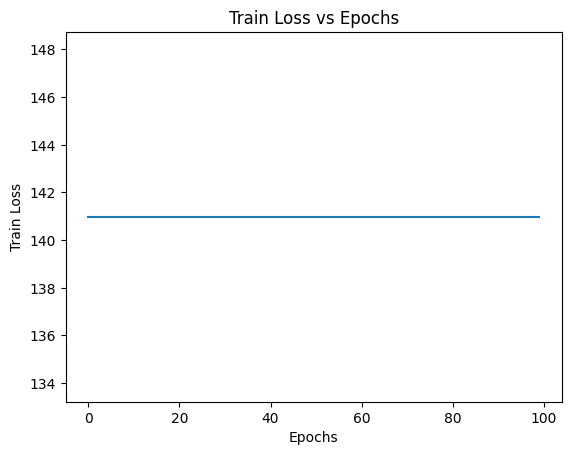

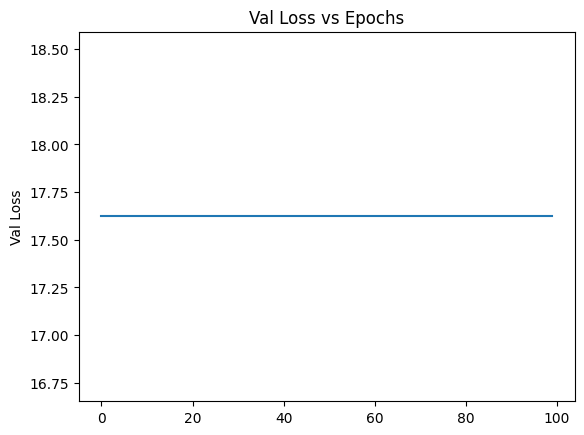

In [36]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with sigmoid activation and weights initialized using normal initialization

In [37]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.02
num_epochs = 100
batch_size = 128
activation_function = sigmoid
weight_initialization_function = normal_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 142.1237
Epoch 1, Val Loss: 17.7476
Epoch 2, Train Loss: 140.9746
Epoch 2, Val Loss: 17.6109
Epoch 3, Train Loss: 140.8564
Epoch 3, Val Loss: 17.5991
Epoch 4, Train Loss: 140.8351
Epoch 4, Val Loss: 17.5975
Epoch 5, Train Loss: 140.8222
Epoch 5, Val Loss: 17.5963
Epoch 6, Train Loss: 140.8097
Epoch 6, Val Loss: 17.5949
Epoch 7, Train Loss: 140.7971
Epoch 7, Val Loss: 17.5933
Epoch 8, Train Loss: 140.7844
Epoch 8, Val Loss: 17.5918
Epoch 9, Train Loss: 140.7716
Epoch 9, Val Loss: 17.5902
Epoch 10, Train Loss: 140.7588
Epoch 10, Val Loss: 17.5886
Epoch 11, Train Loss: 140.7458
Epoch 11, Val Loss: 17.5870
Epoch 12, Train Loss: 140.7328
Epoch 12, Val Loss: 17.5854
Epoch 13, Train Loss: 140.7197
Epoch 13, Val Loss: 17.5838
Epoch 14, Train Loss: 140.7065
Epoch 14, Val Loss: 17.5822
Epoch 15, Train Loss: 140.6932
Epoch 15, Val Loss: 17.5805
Epoch 16, Train Loss: 140.6798
Epoch 16, Val Loss: 17.5788
Epoch 17, Train Loss: 140.6662
Epoch 17, Val Loss: 17.5772
Epoch 18, Train

In [38]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "normal_sigmoid.pkl")


Accuracy: 43.416666666666664%


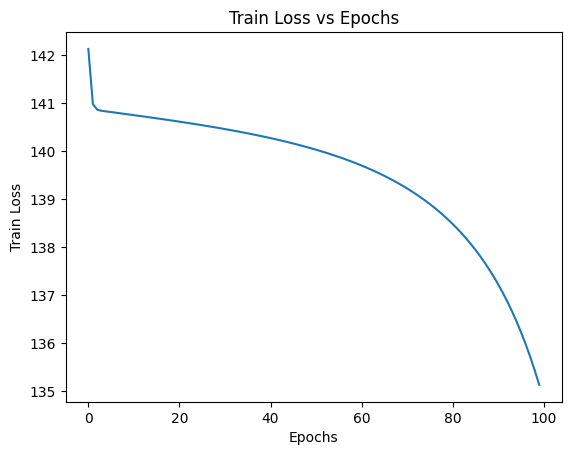

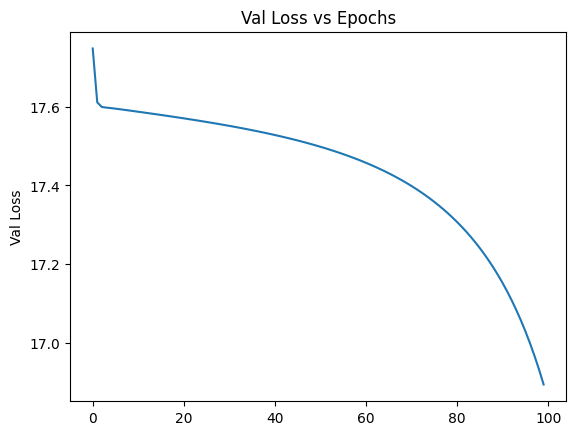

In [39]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with tanh activation and weights initialized using normal initialization

In [40]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = tanh
weight_initialization_function = normal_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 117.1856
Epoch 1, Val Loss: 14.6558
Epoch 2, Train Loss: 98.6020
Epoch 2, Val Loss: 12.3414
Epoch 3, Train Loss: 86.5643
Epoch 3, Val Loss: 10.8448
Epoch 4, Train Loss: 78.2247
Epoch 4, Val Loss: 9.8085
Epoch 5, Train Loss: 72.0355
Epoch 5, Val Loss: 9.0399
Epoch 6, Train Loss: 67.2071
Epoch 6, Val Loss: 8.4408
Epoch 7, Train Loss: 63.3032
Epoch 7, Val Loss: 7.9569
Epoch 8, Train Loss: 60.0604
Epoch 8, Val Loss: 7.5553
Epoch 9, Train Loss: 57.3087
Epoch 9, Val Loss: 7.2150
Epoch 10, Train Loss: 54.9329
Epoch 10, Val Loss: 6.9214
Epoch 11, Train Loss: 52.8523
Epoch 11, Val Loss: 6.6646
Epoch 12, Train Loss: 51.0086
Epoch 12, Val Loss: 6.4374
Epoch 13, Train Loss: 49.3585
Epoch 13, Val Loss: 6.2342
Epoch 14, Train Loss: 47.8692
Epoch 14, Val Loss: 6.0510
Epoch 15, Train Loss: 46.5155
Epoch 15, Val Loss: 5.8848
Epoch 16, Train Loss: 45.2774
Epoch 16, Val Loss: 5.7329
Epoch 17, Train Loss: 44.1389
Epoch 17, Val Loss: 5.5934
Epoch 18, Train Loss: 43.0870
Epoch 18, Val L

In [41]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "normal_tanh.pkl")


Accuracy: 91.26666666666667%


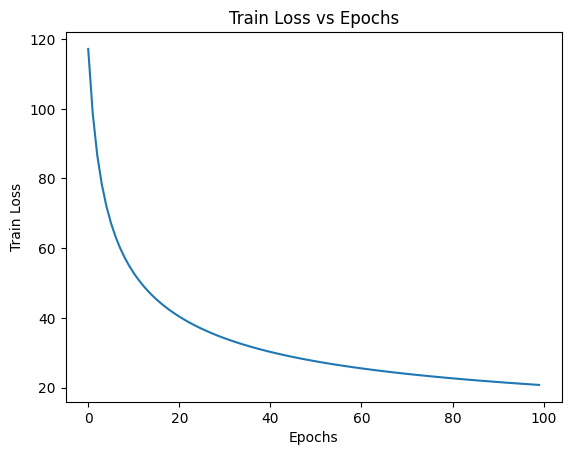

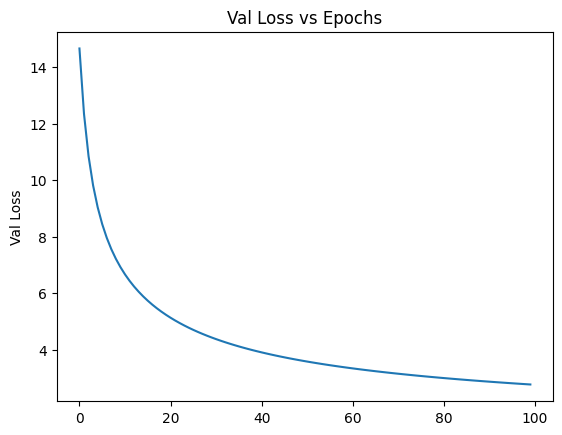

In [42]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with ReLU activation and weights initialized using normal initialization

In [43]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = relu
weight_initialization_function = normal_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 142.7293
Epoch 1, Val Loss: 17.9223
Epoch 2, Train Loss: 139.5802
Epoch 2, Val Loss: 17.5267
Epoch 3, Train Loss: 136.9861
Epoch 3, Val Loss: 17.2031
Epoch 4, Train Loss: 134.3985
Epoch 4, Val Loss: 16.8787
Epoch 5, Train Loss: 131.6654
Epoch 5, Val Loss: 16.5380
Epoch 6, Train Loss: 128.6667
Epoch 6, Val Loss: 16.1655
Epoch 7, Train Loss: 125.4330
Epoch 7, Val Loss: 15.7620
Epoch 8, Train Loss: 122.0891
Epoch 8, Val Loss: 15.3430
Epoch 9, Train Loss: 118.6589
Epoch 9, Val Loss: 14.9144
Epoch 10, Train Loss: 115.1103
Epoch 10, Val Loss: 14.4717
Epoch 11, Train Loss: 111.3428
Epoch 11, Val Loss: 14.0022
Epoch 12, Train Loss: 107.0267
Epoch 12, Val Loss: 13.4649
Epoch 13, Train Loss: 102.0499
Epoch 13, Val Loss: 12.8415
Epoch 14, Train Loss: 96.7685
Epoch 14, Val Loss: 12.1765
Epoch 15, Train Loss: 91.3924
Epoch 15, Val Loss: 11.5022
Epoch 16, Train Loss: 85.9864
Epoch 16, Val Loss: 10.8272
Epoch 17, Train Loss: 80.6279
Epoch 17, Val Loss: 10.1614
Epoch 18, Train Los

In [44]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "normal_relu.pkl")


Accuracy: 91.51666666666667%


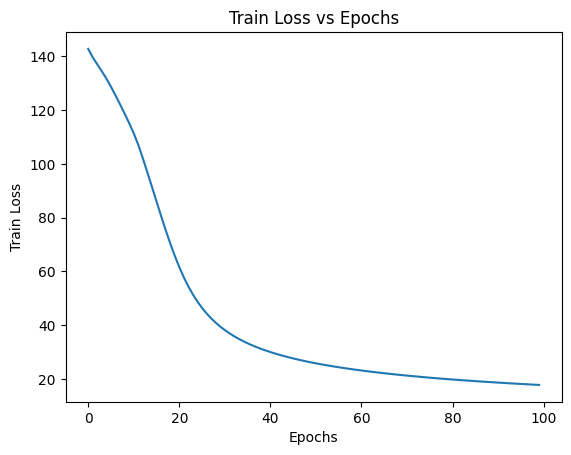

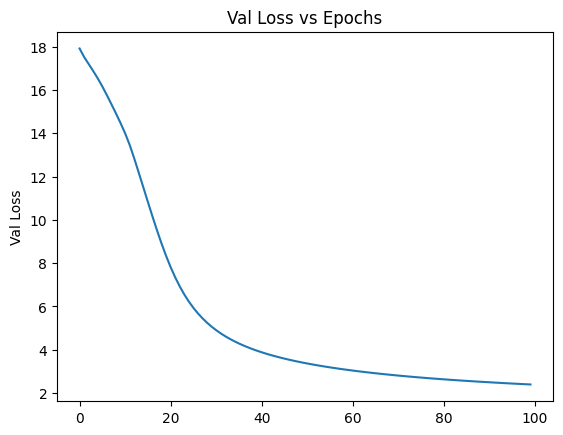

In [45]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with Leaky ReLU activation and weights initialized using normal initialization

In [46]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = leaky_relu
weight_initialization_function = normal_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 140.8397
Epoch 1, Val Loss: 17.6028
Epoch 2, Train Loss: 136.0596
Epoch 2, Val Loss: 17.0217
Epoch 3, Train Loss: 131.6304
Epoch 3, Val Loss: 16.4781
Epoch 4, Train Loss: 126.8380
Epoch 4, Val Loss: 15.8873
Epoch 5, Train Loss: 121.7364
Epoch 5, Val Loss: 15.2573
Epoch 6, Train Loss: 116.4804
Epoch 6, Val Loss: 14.6063
Epoch 7, Train Loss: 111.1498
Epoch 7, Val Loss: 13.9468
Epoch 8, Train Loss: 105.7793
Epoch 8, Val Loss: 13.2823
Epoch 9, Train Loss: 100.3998
Epoch 9, Val Loss: 12.6149
Epoch 10, Train Loss: 95.0048
Epoch 10, Val Loss: 11.9475
Epoch 11, Train Loss: 89.6005
Epoch 11, Val Loss: 11.2771
Epoch 12, Train Loss: 84.1890
Epoch 12, Val Loss: 10.6038
Epoch 13, Train Loss: 78.8285
Epoch 13, Val Loss: 9.9368
Epoch 14, Train Loss: 73.6006
Epoch 14, Val Loss: 9.2864
Epoch 15, Train Loss: 68.6349
Epoch 15, Val Loss: 8.6694
Epoch 16, Train Loss: 64.0279
Epoch 16, Val Loss: 8.1003
Epoch 17, Train Loss: 59.8499
Epoch 17, Val Loss: 7.5866
Epoch 18, Train Loss: 56.105

In [47]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "normal_leaky_relu.pkl")

Accuracy: 92.60000000000001%


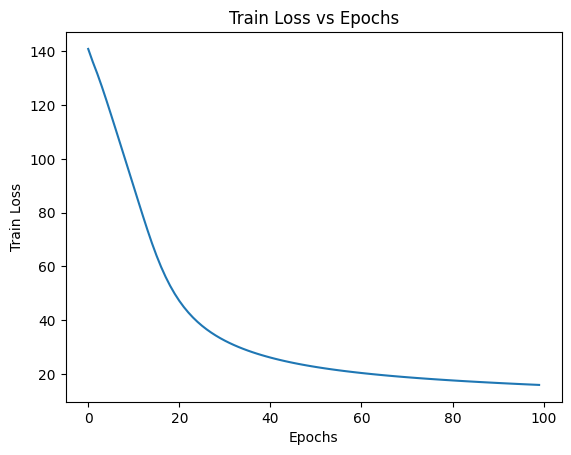

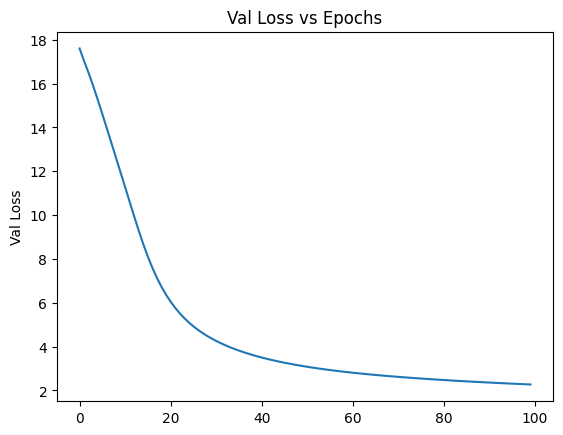

In [48]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with sigmoid activation and weights initialized using random initialization

In [10]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.02
num_epochs = 100
batch_size = 128
activation_function = sigmoid
weight_initialization_function = random_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 141.7779
Epoch 1, Val Loss: 17.7066
Epoch 2, Train Loss: 140.4041
Epoch 2, Val Loss: 17.5393
Epoch 3, Train Loss: 140.0920
Epoch 3, Val Loss: 17.5021
Epoch 4, Train Loss: 139.8561
Epoch 4, Val Loss: 17.4733
Epoch 5, Train Loss: 139.6207
Epoch 5, Val Loss: 17.4442
Epoch 6, Train Loss: 139.3787
Epoch 6, Val Loss: 17.4142
Epoch 7, Train Loss: 139.1279
Epoch 7, Val Loss: 17.3831
Epoch 8, Train Loss: 138.8660
Epoch 8, Val Loss: 17.3506
Epoch 9, Train Loss: 138.5908
Epoch 9, Val Loss: 17.3164
Epoch 10, Train Loss: 138.2998
Epoch 10, Val Loss: 17.2803
Epoch 11, Train Loss: 137.9903
Epoch 11, Val Loss: 17.2418
Epoch 12, Train Loss: 137.6594
Epoch 12, Val Loss: 17.2007
Epoch 13, Train Loss: 137.3037
Epoch 13, Val Loss: 17.1566
Epoch 14, Train Loss: 136.9199
Epoch 14, Val Loss: 17.1089
Epoch 15, Train Loss: 136.5040
Epoch 15, Val Loss: 17.0573
Epoch 16, Train Loss: 136.0519
Epoch 16, Val Loss: 17.0012
Epoch 17, Train Loss: 135.5591
Epoch 17, Val Loss: 16.9400
Epoch 18, Train

In [11]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "random_sigmoid.pkl")

Accuracy: 85.43333333333332%


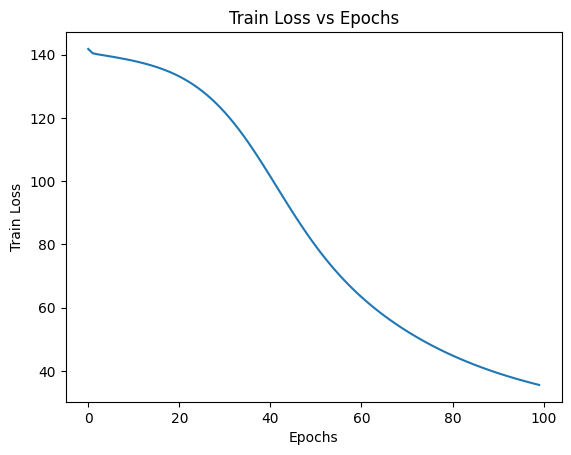

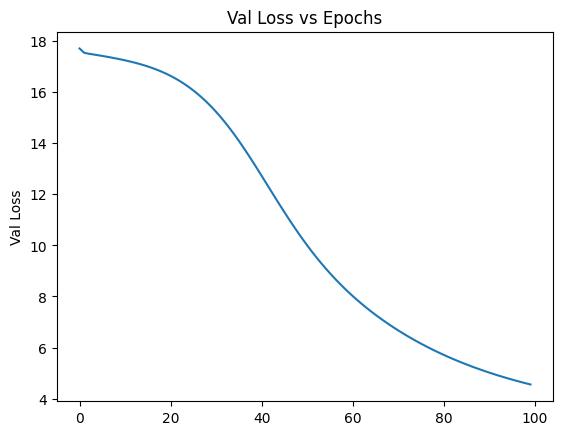

In [12]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with tanh activation and weights initialized using random initialization

In [13]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = tanh
weight_initialization_function = random_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 158.4077
Epoch 1, Val Loss: 19.7296
Epoch 2, Train Loss: 150.6100
Epoch 2, Val Loss: 18.7554
Epoch 3, Train Loss: 143.6881
Epoch 3, Val Loss: 17.8947
Epoch 4, Train Loss: 137.5251
Epoch 4, Val Loss: 17.1318
Epoch 5, Train Loss: 132.0137
Epoch 5, Val Loss: 16.4520
Epoch 6, Train Loss: 127.0556
Epoch 6, Val Loss: 15.8421
Epoch 7, Train Loss: 122.5651
Epoch 7, Val Loss: 15.2909
Epoch 8, Train Loss: 118.4727
Epoch 8, Val Loss: 14.7894
Epoch 9, Train Loss: 114.7227
Epoch 9, Val Loss: 14.3303
Epoch 10, Train Loss: 111.2702
Epoch 10, Val Loss: 13.9080
Epoch 11, Train Loss: 108.0790
Epoch 11, Val Loss: 13.5181
Epoch 12, Train Loss: 105.1193
Epoch 12, Val Loss: 13.1567
Epoch 13, Train Loss: 102.3665
Epoch 13, Val Loss: 12.8207
Epoch 14, Train Loss: 99.7995
Epoch 14, Val Loss: 12.5074
Epoch 15, Train Loss: 97.3995
Epoch 15, Val Loss: 12.2145
Epoch 16, Train Loss: 95.1503
Epoch 16, Val Loss: 11.9400
Epoch 17, Train Loss: 93.0374
Epoch 17, Val Loss: 11.6820
Epoch 18, Train Los

In [14]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "random_tanh.pkl")

Accuracy: 79.21666666666667%


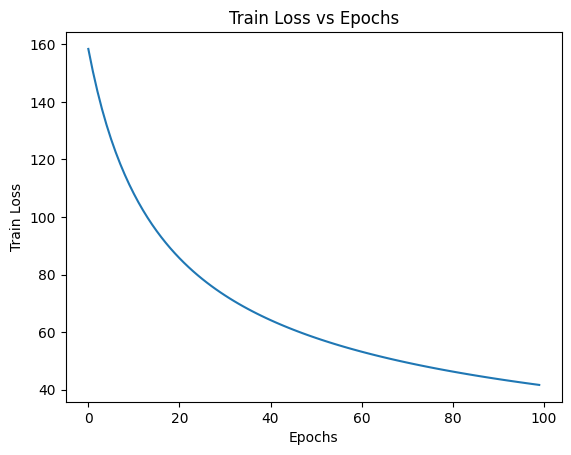

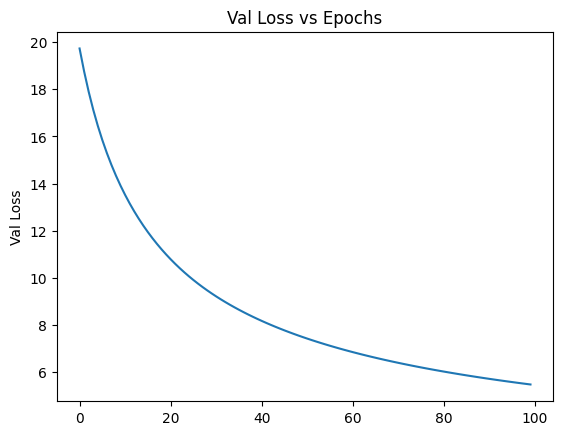

In [15]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with ReLU activation and weights initialized using random initialization

In [16]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = relu
weight_initialization_function = random_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 166.0029
Epoch 1, Val Loss: 20.8990
Epoch 2, Train Loss: 136.3983
Epoch 2, Val Loss: 17.1626
Epoch 3, Train Loss: 125.8449
Epoch 3, Val Loss: 15.8126
Epoch 4, Train Loss: 118.3061
Epoch 4, Val Loss: 14.8479
Epoch 5, Train Loss: 111.8059
Epoch 5, Val Loss: 14.0273
Epoch 6, Train Loss: 105.9542
Epoch 6, Val Loss: 13.2881
Epoch 7, Train Loss: 100.7638
Epoch 7, Val Loss: 12.6360
Epoch 8, Train Loss: 96.1964
Epoch 8, Val Loss: 12.0582
Epoch 9, Train Loss: 92.1375
Epoch 9, Val Loss: 11.5447
Epoch 10, Train Loss: 88.5399
Epoch 10, Val Loss: 11.1003
Epoch 11, Train Loss: 85.3244
Epoch 11, Val Loss: 10.7096
Epoch 12, Train Loss: 82.4441
Epoch 12, Val Loss: 10.3569
Epoch 13, Train Loss: 79.8186
Epoch 13, Val Loss: 10.0372
Epoch 14, Train Loss: 77.4131
Epoch 14, Val Loss: 9.7453
Epoch 15, Train Loss: 75.2027
Epoch 15, Val Loss: 9.4754
Epoch 16, Train Loss: 73.1684
Epoch 16, Val Loss: 9.2268
Epoch 17, Train Loss: 71.2956
Epoch 17, Val Loss: 8.9980
Epoch 18, Train Loss: 69.5585

In [17]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "random_relu.pkl")

Accuracy: 83.28333333333333%


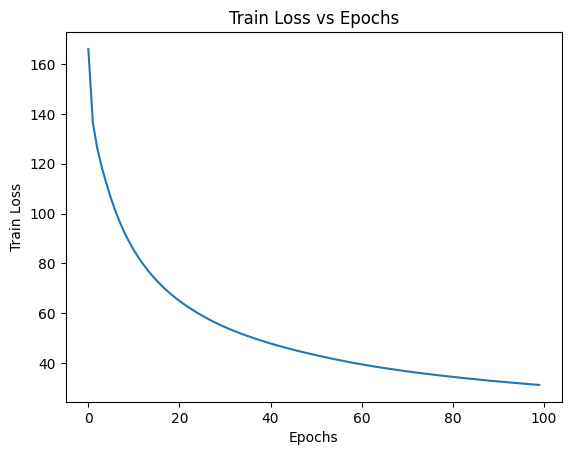

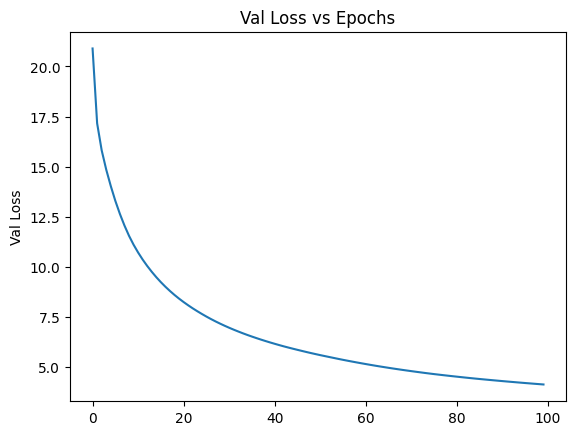

In [18]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Training the model with Leaky ReLU activation and weights initialized using random initialization

In [19]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.002
num_epochs = 100
batch_size = 128
activation_function = leaky_relu
weight_initialization_function = random_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 201.1271
Epoch 1, Val Loss: nan


C:\Users\Aditya\AppData\Local\Temp\ipykernel_21044\3878244297.py:98: RuntimeWarning: divide by zero encountered in log
  val_loss = -np.sum(val_Y * np.log(prediction_val)) / val_X.shape[0]
C:\Users\Aditya\AppData\Local\Temp\ipykernel_21044\3878244297.py:98: RuntimeWarning: invalid value encountered in multiply
  val_loss = -np.sum(val_Y * np.log(prediction_val)) / val_X.shape[0]


Epoch 2, Train Loss: 133.7446
Epoch 2, Val Loss: nan
Epoch 3, Train Loss: 111.2591
Epoch 3, Val Loss: nan
Epoch 4, Train Loss: 99.7489
Epoch 4, Val Loss: nan
Epoch 5, Train Loss: 92.1229
Epoch 5, Val Loss: nan
Epoch 6, Train Loss: 86.3685
Epoch 6, Val Loss: nan
Epoch 7, Train Loss: 81.7505
Epoch 7, Val Loss: nan
Epoch 8, Train Loss: 77.8796
Epoch 8, Val Loss: nan
Epoch 9, Train Loss: 74.5662
Epoch 9, Val Loss: nan
Epoch 10, Train Loss: 71.6823
Epoch 10, Val Loss: nan
Epoch 11, Train Loss: 69.1386
Epoch 11, Val Loss: nan
Epoch 12, Train Loss: 66.8736
Epoch 12, Val Loss: nan
Epoch 13, Train Loss: 64.8378
Epoch 13, Val Loss: nan
Epoch 14, Train Loss: 62.9882
Epoch 14, Val Loss: nan
Epoch 15, Train Loss: 61.2934
Epoch 15, Val Loss: nan
Epoch 16, Train Loss: 59.7424
Epoch 16, Val Loss: nan
Epoch 17, Train Loss: 58.3064
Epoch 17, Val Loss: nan
Epoch 18, Train Loss: 56.9628
Epoch 18, Val Loss: nan
Epoch 19, Train Loss: 55.7052
Epoch 19, Val Loss: nan
Epoch 20, Train Loss: 54.5279
Epoch 20, Va

In [20]:
def save_model(nn, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(nn, f)

# Save the trained model
save_model(nn, "random_leaky_relu.pkl")

Accuracy: 86.26666666666667%


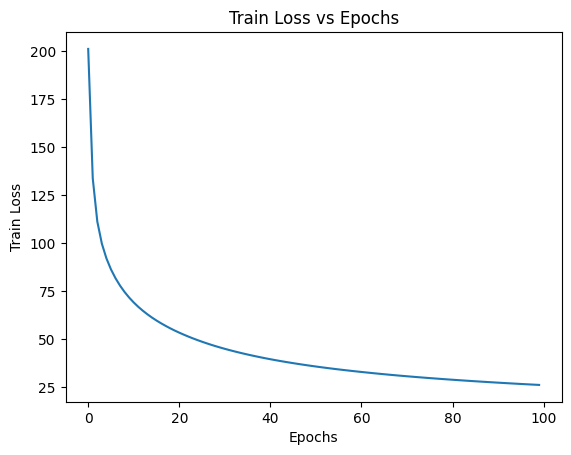

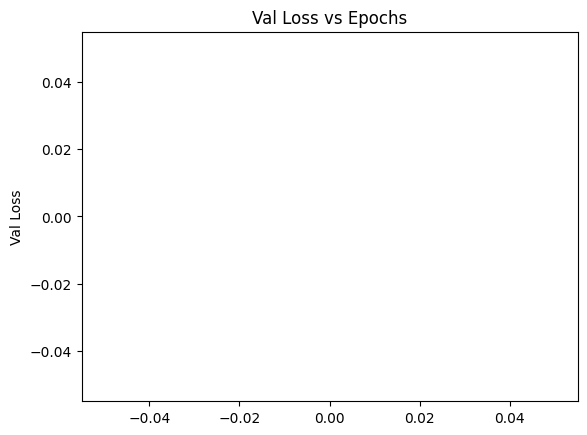

In [21]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Demonstration of Overfitting with large learning rate (=0.1)

In [22]:
train_losses = []
val_losses = []

N = 4
layer_sizes = [256,128,64,32]

learning_rate = 0.1
num_epochs = 100
batch_size = 128
activation_function = leaky_relu
weight_initialization_function = normal_init

nn = NeuralNetwork(N=N, layer_sizes=layer_sizes, lr=learning_rate, act_fn=activation_function,
                   weight_init_fn=weight_initialization_function, num_epochs=num_epochs, batch_size=batch_size)

nn.fit(train_set, train_labels, val_set, val_labels)

Epoch 1, Train Loss: 25.2906
Epoch 1, Val Loss: 3.3423
Epoch 2, Train Loss: 18.2220
Epoch 2, Val Loss: 2.5305
Epoch 3, Train Loss: 15.1710
Epoch 3, Val Loss: 2.1706
Epoch 4, Train Loss: 13.1755
Epoch 4, Val Loss: 1.9380
Epoch 5, Train Loss: 11.5928
Epoch 5, Val Loss: 1.7523
Epoch 6, Train Loss: 10.2551
Epoch 6, Val Loss: 1.5957
Epoch 7, Train Loss: 9.1366
Epoch 7, Val Loss: 1.4694
Epoch 8, Train Loss: 8.2582
Epoch 8, Val Loss: 1.3726
Epoch 9, Train Loss: 7.5018
Epoch 9, Val Loss: 1.2920
Epoch 10, Train Loss: 6.8842
Epoch 10, Val Loss: 1.2292
Epoch 11, Train Loss: 6.3227
Epoch 11, Val Loss: 1.1720
Epoch 12, Train Loss: 5.8444
Epoch 12, Val Loss: 1.1264
Epoch 13, Train Loss: 5.4036
Epoch 13, Val Loss: 1.0855
Epoch 14, Train Loss: 5.0242
Epoch 14, Val Loss: 1.0531
Epoch 15, Train Loss: 4.6847
Epoch 15, Val Loss: 1.0262
Epoch 16, Train Loss: 4.3754
Epoch 16, Val Loss: 1.0025
Epoch 17, Train Loss: 4.0961
Epoch 17, Val Loss: 0.9850
Epoch 18, Train Loss: 3.8468
Epoch 18, Val Loss: 0.9712
Epoc

Accuracy: 97.43333333333334%


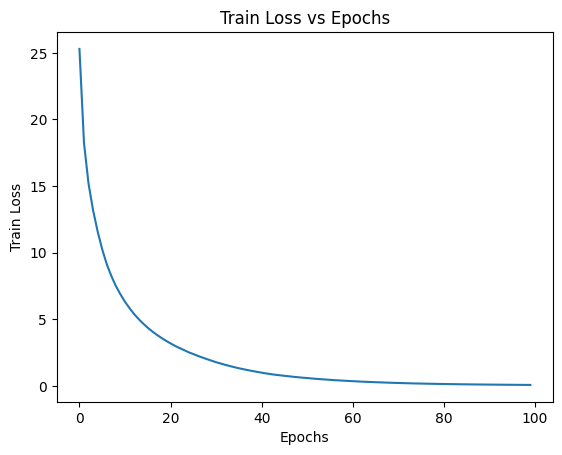

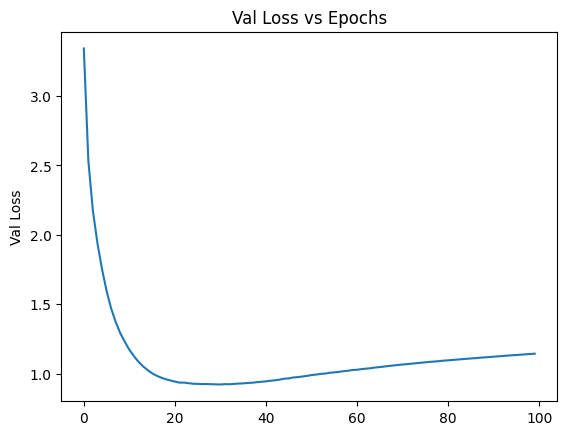

In [23]:
score = nn.score(test_set, test_labels)
print(f"Accuracy: {score*100}%")
plot_loss()

Function to load the saved models

In [27]:
def load_model(model_name):
    with open(model_name+".pkl", "rb") as file:
        loaded_model = pickle.load(file)
    return loaded_model

Printing accuracies

In [28]:
model_names = ["zero_sigmoid", "zero_tanh", "zero_relu", "zero_leaky_relu", "random_sigmoid", "random_tanh", "random_relu", "random_leaky_relu", "normal_sigmoid", "normal_tanh", "normal_relu", "normal_leaky_relu"]
accuracies = []
for model_name in model_names:
    accuracy = load_model(model_name).score(test_set, test_labels)*100
    accuracies.append(accuracy)
    print(f"Accuracy of {model_name}: {accuracy}%")

Accuracy of zero_sigmoid: 11.233333333333333%
Accuracy of zero_tanh: 9.816666666666666%
Accuracy of zero_relu: 9.816666666666666%
Accuracy of zero_leaky_relu: 9.816666666666666%
Accuracy of random_sigmoid: 85.43333333333332%
Accuracy of random_tanh: 79.21666666666667%
Accuracy of random_relu: 83.28333333333333%
Accuracy of random_leaky_relu: 86.26666666666667%
Accuracy of normal_sigmoid: 43.416666666666664%
Accuracy of normal_tanh: 91.26666666666667%
Accuracy of normal_relu: 91.51666666666667%
Accuracy of normal_leaky_relu: 92.60000000000001%


Comparison of models using accuracies and bar graph

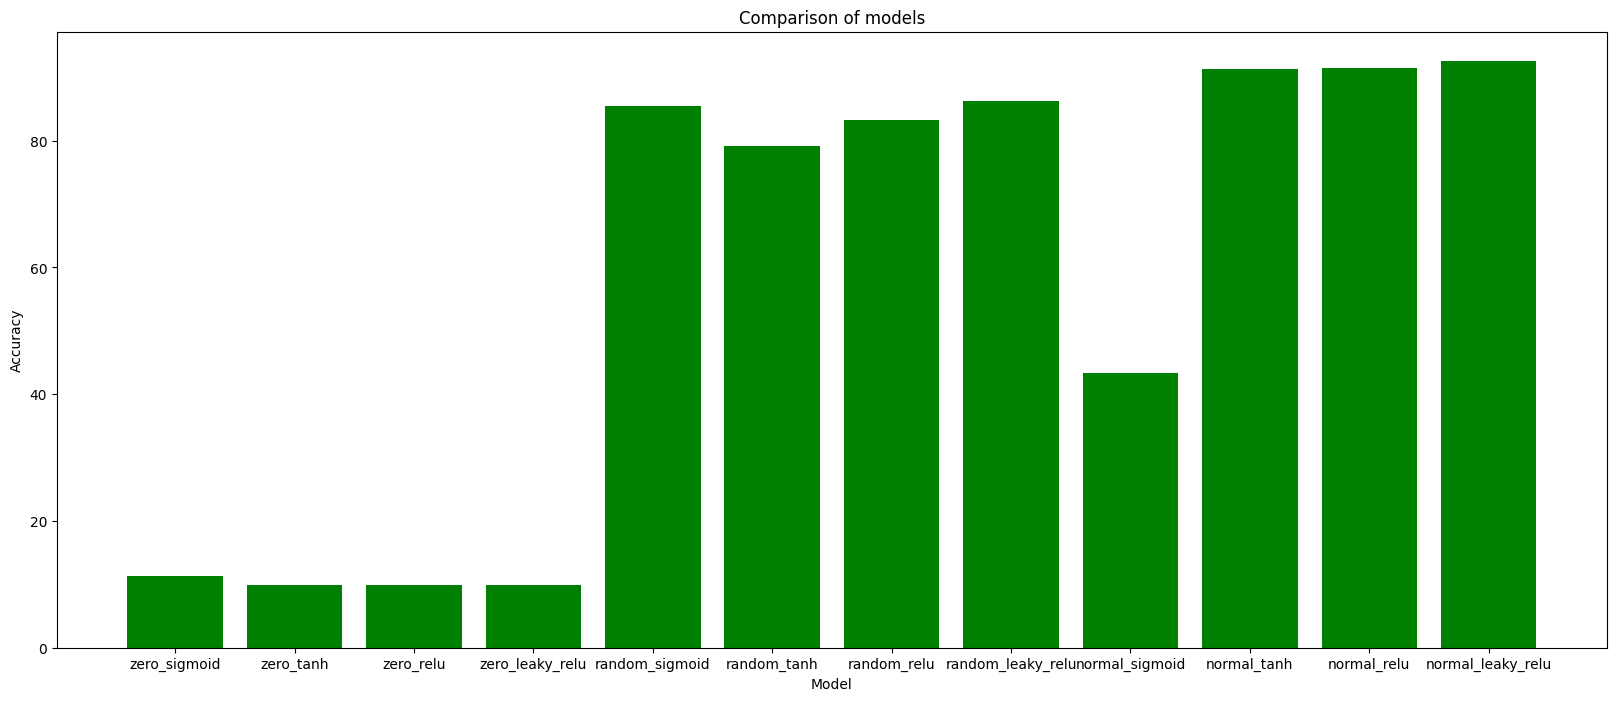

In [34]:
plt.figure(figsize=(20, 8))
plt.bar(model_names, accuracies, color='green') 

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of models')

plt.show()